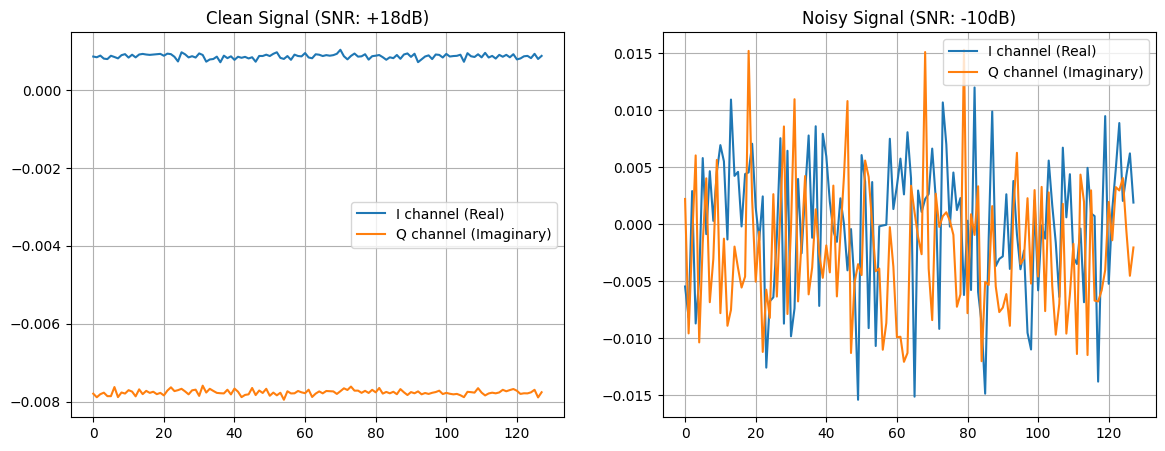

In [1]:
import pickle
import matplotlib.pyplot as plt

# 1. 다운로드한 피클(pkl) 파일 불러오기
# 파이썬 3에서는 encoding='latin1' 옵션이 반드시 필요합니다.
file_path = '/content/RML2016.10a_dict.pkl' # 파일이 있는 경로에 맞게 수정해주세요
with open(file_path, 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')

# Xd 데이터는 (모듈레이션, SNR)을 Key로 갖는 딕셔너리입니다.
# 예: b'QPSK'라는 통신 방식을 사용해볼게요.

# 2. 노이즈가 없는 깨끗한 신호 (SNR이 +18dB로 아주 높을 때)
clean_signal = Xd[('AM-DSB', 18)][0] # 첫 번째 샘플 가져오기 (Shape: 2 x 128)

# 3. 노이즈가 극심한 신호 (SNR이 -10dB로 낮을 때 / AWGN 환경)
noisy_signal = Xd[('AM-DSB', -10)][0]

# 4. 시계열 그래프(Time-Series Plot) 그리기
plt.figure(figsize=(14, 5))

# --- 깨끗한 신호 그래프 ---
plt.subplot(1, 2, 1)
plt.plot(clean_signal[0], label='I channel (Real)')
plt.plot(clean_signal[1], label='Q channel (Imaginary)')
plt.title('Clean Signal (SNR: +18dB)')
plt.legend()
plt.grid(True)

# --- 지지직거리는 노이즈 신호 그래프 ---
plt.subplot(1, 2, 2)
plt.plot(noisy_signal[0], label='I channel (Real)')
plt.plot(noisy_signal[1], label='Q channel (Imaginary)')
plt.title('Noisy Signal (SNR: -10dB)')
plt.legend()
plt.grid(True)

#sum_signal = noisy_signal[0] + noisy_signal[1]
#plt.figure(figsize=(14, 5))
#plt.plot(sum_signal)

plt.show()

In [2]:
import torch
import torch.nn as nn

class BasicModulationCNN(nn.Module):
    def __init__(self, num_classes=11): # RadioML 2016.10a는 11개 클래스
        super(BasicModulationCNN, self).__init__()

        # 1. 첫 번째 특징 추출기 (시간 축을 따라 패턴 찾기)
        # in_channels=2 (I와 Q 채널), out_channels=64 (64개의 다른 특징을 찾겠다)
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7, padding=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2) # 시간 길이를 반(128 -> 64)으로 줄임

        # 2. 두 번째 특징 추출기 (더 복잡한 주파수/위상 변화 찾기)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2) # 시간 길이를 또 반(64 -> 32)으로 줄임

        # 3. 분류기 (찾아낸 특징들을 종합해서 11개 중 하나로 결정)
        # 특징 128개 * 남은 시간 길이 32 = 4096
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes) # 최종 출력: 11개의 클래스 확률(Logits)

    def forward(self, x):
        # x의 입력 형태: (Batch_Size, 2, 128) = (Batch_Size, i and q, time steps)

        x = self.pool1(self.relu1(self.conv1(x)))
        # Conv1 통과 후 형태: (Batch_Size, 64, 64)

        x = self.pool2(self.relu2(self.conv2(x)))
        # Conv2 통과 후 형태: (Batch_Size, 128, 32)

        x = self.flatten(x)
        # Flatten 후 형태: (Batch_Size, 4096)

        x = self.relu3(self.fc1(x))
        # FC1 통과 후 형태: (Batch_Size, 256)

        out = self.fc2(x)
        # 최종 출력 형태: (Batch_Size, 11)

        return out

# 모델 테스트 (가상의 데이터 하나를 통과시켜보기)
model = BasicModulationCNN()
dummy_data = torch.randn(1, 2, 128) # (배치 1개, 2채널, 128길이)의 가짜 노이즈 생성
output = model(dummy_data)

print("입력 데이터 형태:", dummy_data.shape)
print("출력 데이터 형태:", output.shape)
# 출력 결과의 11개 숫자 중 가장 큰 값의 인덱스가 AI가 예측한 변조 방식(예: QAM16)이 됩니다.





#convolution 공학적 의미: kernel이 I, Q (Channels)를 7개씩(t~t+6) 묶어서 연산 진행
#-> time-series에 따른 pattern(phase shift)을 찾아냄 = modulation prediction(frequency detector) 동작
#maxpooling 공학적 의미: time step의 길이를 반으로 줄여 -> noise(AWGN)를 무시하고 가장 강력하고 특징적인 파동(peak) 남겨 -> 모델을 robust하게 만듦

입력 데이터 형태: torch.Size([1, 2, 128])
출력 데이터 형태: torch.Size([1, 11])


In [11]:
import torch
import torch.nn as nn

class Modulation_CNN_LSTM(nn.Module):
    def __init__(self, num_classes=11):
        super(Modulation_CNN_LSTM, self).__init__()

        # 1. 공간적/주파수적 특징 추출 (CNN)
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7, padding=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        #(Batch_Size, 2, 128) -> (Batch_Size, 64, 64)

        # 2. 시계열적 흐름 기억 (LSTM)
        # CNN을 통과해 압축된 64개의 특징이 시간 축을 따라 LSTM에 입력됨
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True)
        #nn.LSTM output: 전체 시간 출력, 마지막 hidden
        #(Batch_Size, 64, 128)

        # 3. 최종 분류기
        self.fc = nn.Linear(128, num_classes)
        #(Batch_Size, 64->1(이전에 변환), 11(=num_classes))

    def forward(self, x):
        # x shape: (Batch, 2, 128) - I/Q 시계열 데이터

        x = self.pool(self.relu(self.conv1(x)))
        # CNN 통과 후: (Batch, 64, 64) -> 64개의 특징이 64개의 시간 스텝으로 존재

        # LSTM은 (Batch, Seq_Length, Features) 형태를 원하므로 차원 순서 변경
        x = x.transpose(1, 2)
        # 변경 후: (Batch, 64, 64) -> (Batch, 시간 스텝 64, 특징 64)

        # LSTM 통과 (out은 전체 시간의 출력, hidden은 마지막 순간의 기억)
        out, (hn, cn) = self.lstm(x)

        # 가장 마지막 시간 스텝의 출력값만 사용하여 분류
        final_state = out[:, -1, :]
        #(Batch_Size, 128)

        return self.fc(final_state)
        #(Batch_Size, 11)

model = Modulation_CNN_LSTM()
dummy_data = torch.randn(1, 2, 128) # (배치 1개, 2채널, 128길이)의 가짜 노이즈 생성
output = model(dummy_data) #(1, 11(logit))

In [12]:
import torch.nn.functional as F

class_names = ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK',
               'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
probability = F.softmax(output, dim=1)
pred_index = torch.argmax(probability, dim=1)
pred_class = class_names[pred_index]
confidence = probability[0][pred_index].item()*100

print(f"모델 변조 방식:{pred_class}, 신뢰도:{confidence}")

모델 변조 방식:GFSK, 신뢰도:10.084468871355057
